## Introduction to Classification
In the ***Analysis*** phase, we will take the cleansed data from the ***Process*** phase, and start building a classifier.  For classification, we will use the ***sci-kit learn*** package in Anaconda.  Install that by going to your Anaconda command line and typing ***conda install scikit-learn***

## Decision Trees
Let's start by growing a decision tree from the data

In [39]:
# Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Workshop Functions
import sys
sys.path.append('..')
from Wksp722_functions import * 

In [40]:
# Read in the data
df = pd.read_csv("titanic_train_cleaned.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr.


### Need for additional data processing
The scikit-learn machine learning package can't take **categorical** data as input.  As a result, we will not be able to use the 'Name' or 'Ticket' columns.  

For 'Sex', we can replace 'male' as 0 and 'female' as 1.  Similarly we can replace 'Embarked' as either 0,1, or 2 based on the value.  

In [41]:
# convert the categorical variable 'Sex' to numerical 0 and 1 using mapping
mapping = {'male':0, 'female':1}
df.loc[:,'Sex'] = df.loc[:,'Sex'].map(mapping)
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,Mrs.


For 'Embarked' there are 3 possible values: S, C, and Q.  Rather than assign them values of 0,1,2 respectively, let's use one-hot encoding to create 3 new columns for each value.  In the 'S' column, the value will be a 1 if the original 'Embarked' column has a 'S' as the value for that passenger, and a '0' otherwise.  Similarly for C and Q columns.  

Let's also do the same with the Salutation.  

Finally, let's drop 'PassengerId' as it's really just an index and will not help train the model.  

In [42]:
dfTemp = pd.get_dummies(df.loc[:,['Embarked','Salutation']],dtype=int)

df = pd.concat([df,dfTemp], axis=1)
df.drop(['PassengerId','Embarked','Name','Ticket','Salutation'], axis=1,inplace=True)

In [43]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,...,Salutation_Major.,Salutation_Master.,Salutation_Miss.,Salutation_Mlle.,Salutation_Mme.,Salutation_Mr.,Salutation_Mrs.,Salutation_Ms.,Salutation_Rev.,Salutation_Sir.
0,0,3,0,22.0,1,0,7.2500,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,1,38.0,1,0,71.2833,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,35.0,1,0,53.1000,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,3,0,35.0,0,0,8.0500,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [44]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Salutation_Capt.',
       'Salutation_Col.', 'Salutation_Countess.', 'Salutation_Don.',
       'Salutation_Dr.', 'Salutation_Jonkheer.', 'Salutation_Lady.',
       'Salutation_Major.', 'Salutation_Master.', 'Salutation_Miss.',
       'Salutation_Mlle.', 'Salutation_Mme.', 'Salutation_Mr.',
       'Salutation_Mrs.', 'Salutation_Ms.', 'Salutation_Rev.',
       'Salutation_Sir.'],
      dtype='object')

This seems like we just added a lot of extra columns, but it will make little difference to the computational speed for this dataset. 

I've saved all the changes we did in a function that we can use in the future.  It is located in the class library file.  This step is optional, but can be useful if you have test sets that you need to process in the exact same way as your training set.  

In [45]:
#titanicNumericalConverter(df)

In [46]:
df.head(0).to_csv('titanic_train_columns.csv') # <-- we'll need this information later

### Growing our first classifier - Decision Tree
Now that all the variables are **numerical**, we can use scikit-learn to grow our classifiers.  We'll start by designating one of the columns as the **target variable (y)** and the others will be the **input (x)**.

In [47]:
x = df.drop(columns="Survived")
y = df.loc[:,'Survived']

In [48]:
# the number of survivors is less than the number that didn't survive.  
# Though this is an imbalance, there are several hundred examples of each and should suffice for training our algorithms.
y.value_counts()

0    547
1    336
Name: Survived, dtype: int64

Now we'll split the dataframe into a training and test set.  We'll choose the training set to be 70% of the original size and the test set to be 30%.  

We'll use a built-in function from the scikit-learn (sklearn) package

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=1)

The scikit-learn package has many different kinds of classifiers.  They generally share many common features in how you use them, which makes it easy to call compare the performance of different classifiers.

**The usual sequence of steps of using most classifiers in scikit-learn** is:
* split data into training and testing sets using ***train_test_split***
* import and set the desired classifier
* fit the model to the training data
* predict for the test set using the ***predict*** function
* measure success using accuracy, f1, precision, recall, etc.

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree1 = DecisionTreeClassifier(max_depth =3, random_state = 1)
tree1.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=1)

In [51]:
x_train.size

16068

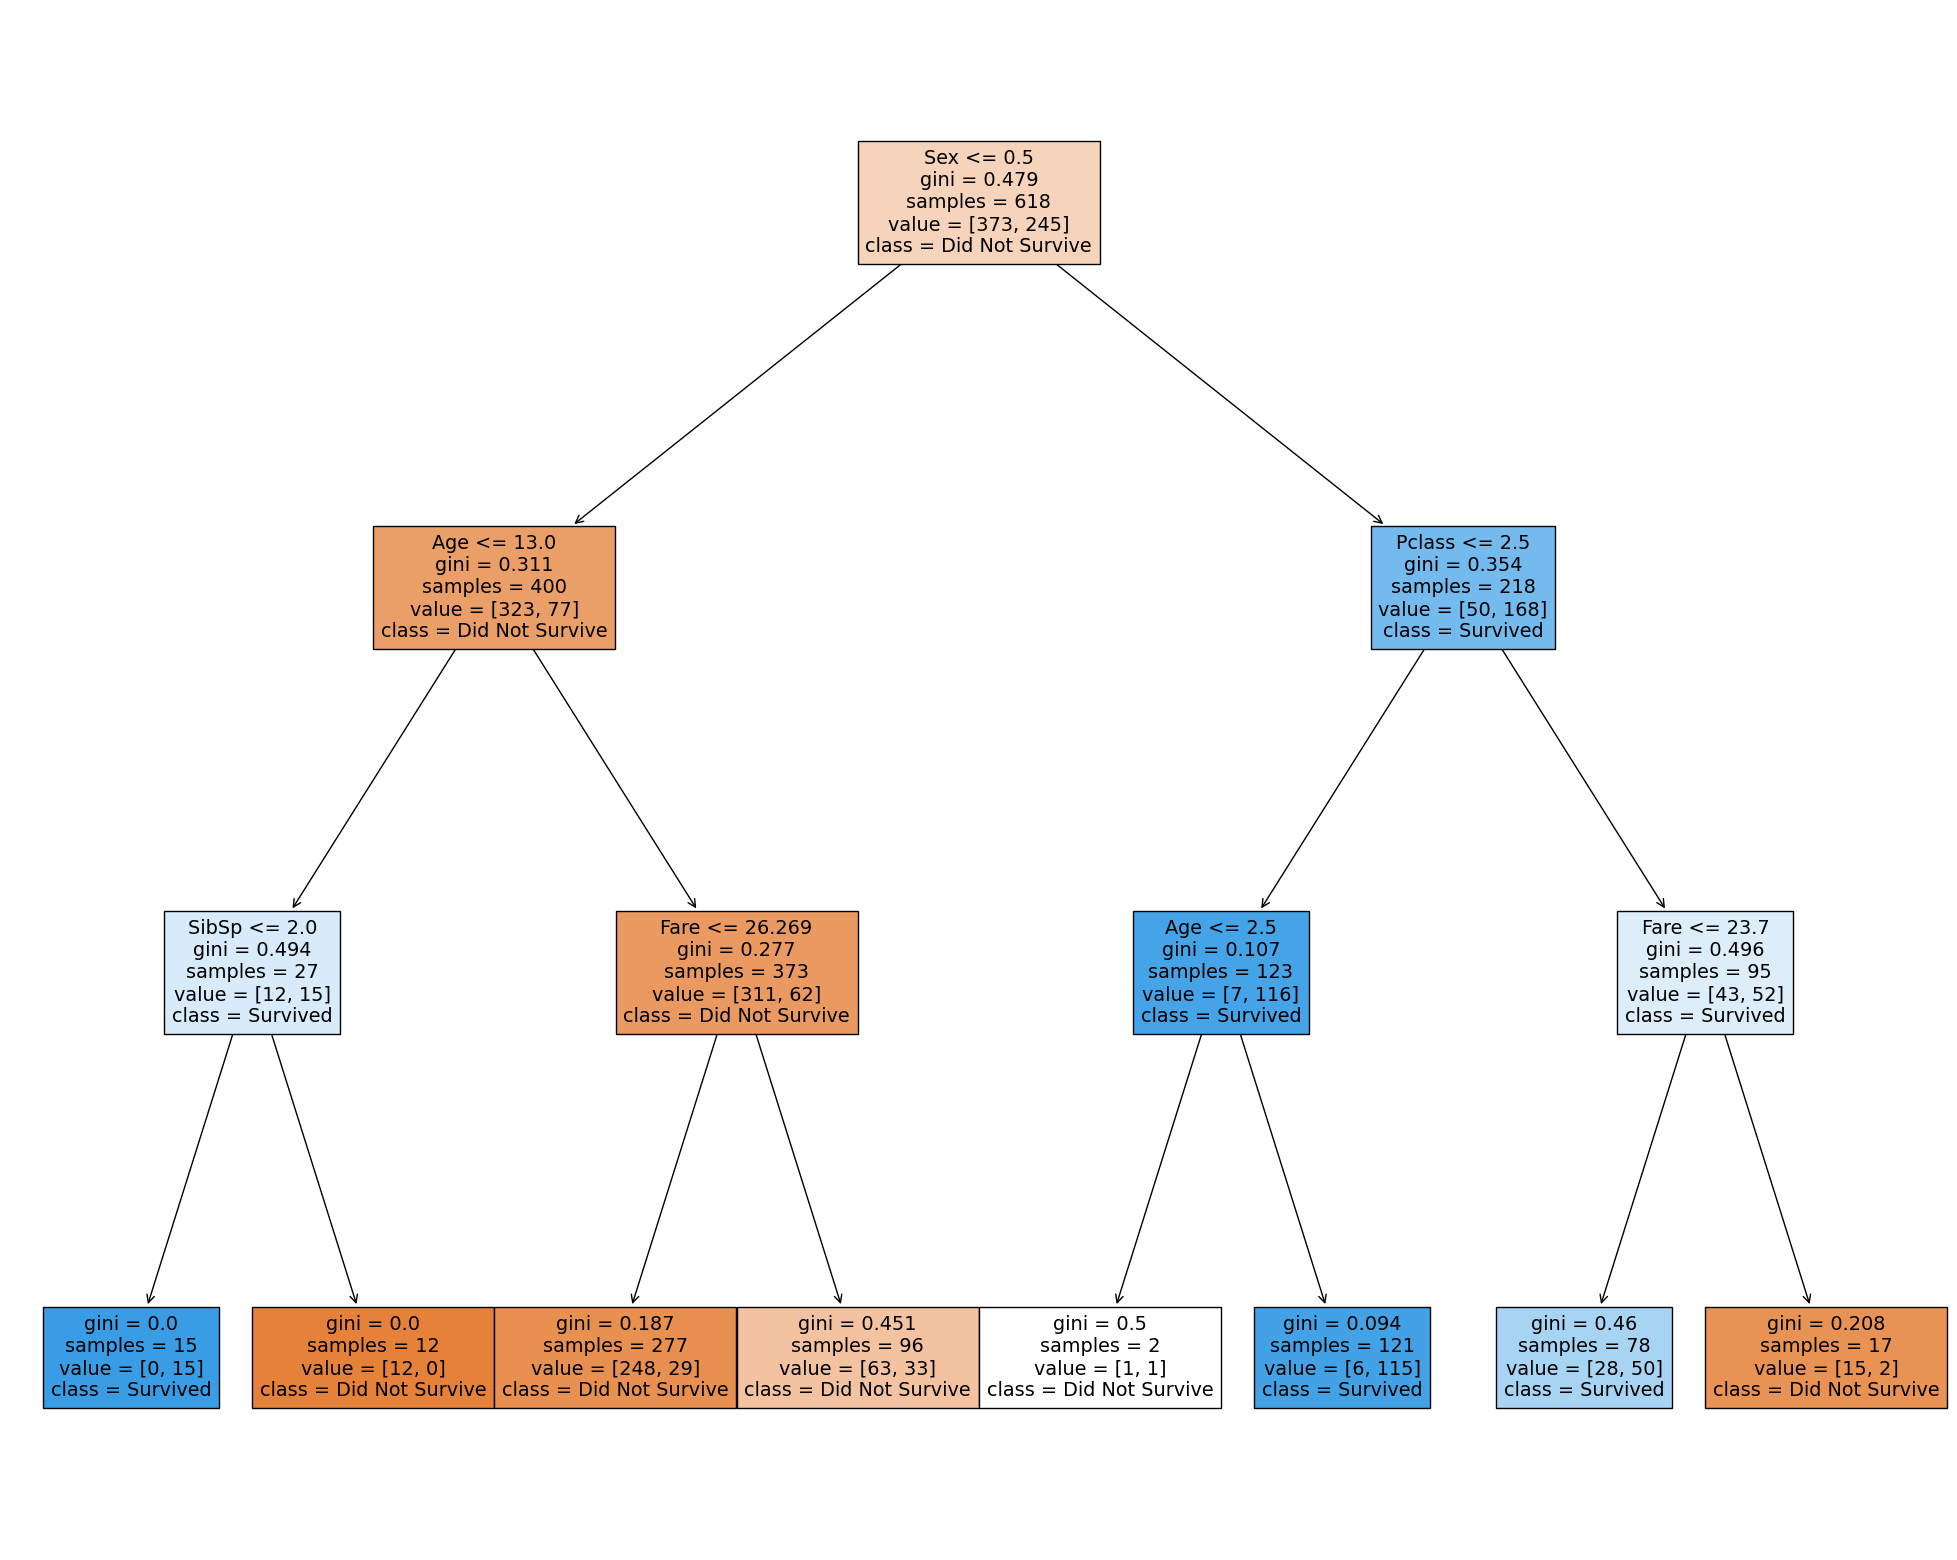

In [36]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))

featureNames = x_train.columns
targetNames = ['Did Not Survive','Survived']
tree.plot_tree(tree1, feature_names=featureNames,  
                   class_names=targetNames,
                   filled=True)

fig.savefig('tree1.pdf')

***Curiosity points (5 Points)***
Another cool package for visualization is dtreeviz.  Install the package with ***conda install dtreeviz***.

See the kaggle notebook at this link (https://www.kaggle.com/code/immu123/decision-tree-visualization-with-dtreeviz?scriptVersionId=101370052) and try visualizing your tree this way.  Below is an example of what the package can do with the iris dataset:

<div>
<img src = "dtreeviz_example.PNG" width="500">
</div>

Some branches lead to a leaf, but many are still mixed at their terminal nodes.  Let's see the accuracy with a relatively short tree:

In [38]:
from sklearn import metrics
y_pred = tree1.predict(x_test)

print("Tree1 Confusion Matrix \n", metrics.confusion_matrix(y_test, y_pred))
print("\n")
print("Tree1 Classification Report \n", metrics.classification_report(y_test, y_pred))
print("\n")
print("Tree1 Accuracy:",metrics.accuracy_score(y_test, y_pred))

Tree1 Confusion Matrix 
 [[150  24]
 [ 25  66]]


Tree1 Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       174
           1       0.73      0.73      0.73        91

    accuracy                           0.82       265
   macro avg       0.80      0.79      0.79       265
weighted avg       0.81      0.82      0.81       265



Tree1 Accuracy: 0.8150943396226416


In [15]:
# grow a full length decision tree and check accuracy
tree2 = DecisionTreeClassifier(max_depth=None, random_state = 1)
tree2.fit(x_train, y_train)
y_pred2 = tree2.predict(x_test)
print("Tree2 Accuracy:",metrics.accuracy_score(y_test, y_pred2))

Tree2 Accuracy: 0.7811320754716982


In [40]:
tree2.tree_.max_depth

22

***Curiosity Points (5 points)*** 
Why did the accuracy drop when we grew a larger tree?  
(hint: use tree2.tree_.max_depth to see how large your tree grew)

## Random Forest classification

In this section, let's use the Random Forest algorithm

In [16]:
from sklearn.ensemble import RandomForestClassifier

RF1 = RandomForestClassifier(n_estimators=125, max_depth=None, oob_score=True, random_state=1)
RF1.fit(x_train, y_train)

y_pred = RF1.predict(x_test)
print("RF1 Accuracy:",metrics.accuracy_score(y_test, y_pred))

RF1 Accuracy: 0.8037735849056604


In [39]:
x_train.isnull().sum()

Pclass                  0
Sex                     0
Age                     0
SibSp                   0
Parch                   0
Fare                    0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Salutation_Capt.        0
Salutation_Col.         0
Salutation_Countess.    0
Salutation_Don.         0
Salutation_Dr.          0
Salutation_Jonkheer.    0
Salutation_Lady.        0
Salutation_Major.       0
Salutation_Master.      0
Salutation_Miss.        0
Salutation_Mlle.        0
Salutation_Mme.         0
Salutation_Mr.          0
Salutation_Mrs.         0
Salutation_Ms.          0
Salutation_Rev.         0
Salutation_Sir.         0
dtype: int64

In [17]:
importances = RF1.feature_importances_
forest_importances = pd.Series(importances, index=x_train.columns) #cast the list into a Pandas series

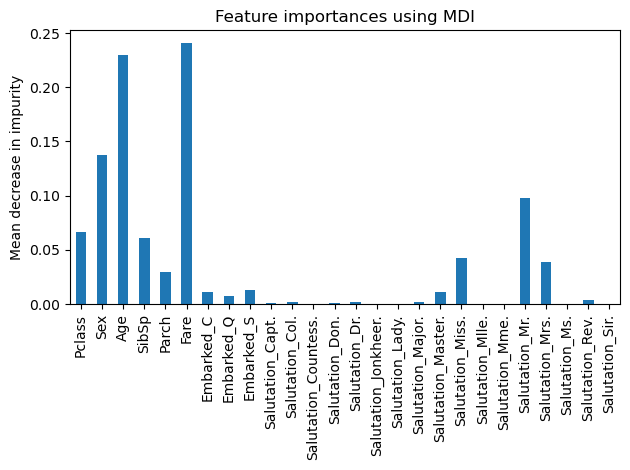

In [18]:
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

I created an additional function that plots the test error and optional Out of Bag (OOB) error as the forest grows.  It is located in the class library file.  

In [19]:
# def EnsembleGrowthErrorPlot(clf,x_train,y_train,x_test,y_test,min_estimators=5,max_estimators=200,oob=False):

C:\Users\hiren\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\hiren\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\hiren\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


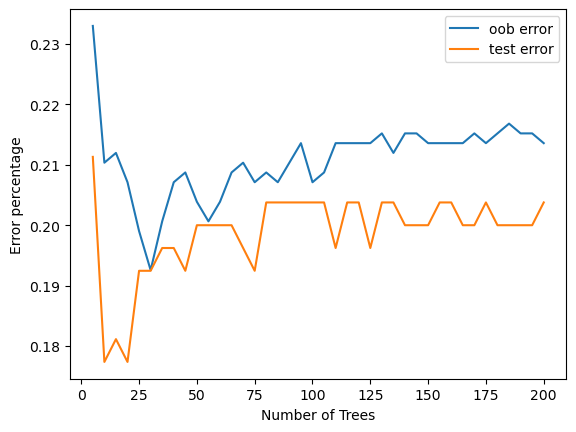

In [20]:
EnsembleGrowthErrorPlot(RF1, x_train, y_train, x_test, y_test, min_estimators =5, max_estimators =200, oob =True)

We see that there is a large drop in error around 25 trees, and a slighter drop in error around 120 trees.  Also there is good agreement between the test and out-of-bag error rates.  

Let's see how other things effect accuracy

In [21]:
test_error = []
for i in range(2,25,1):
        RF2 = RandomForestClassifier(n_estimators=125, max_depth=None, oob_score=True, random_state=1, min_samples_split=i)
        RF2.fit(x_train, y_train)

        y_pred = RF2.predict(x_test)
        acc = metrics.accuracy_score(y_test, y_pred)
        test_error.append((i,1-acc))

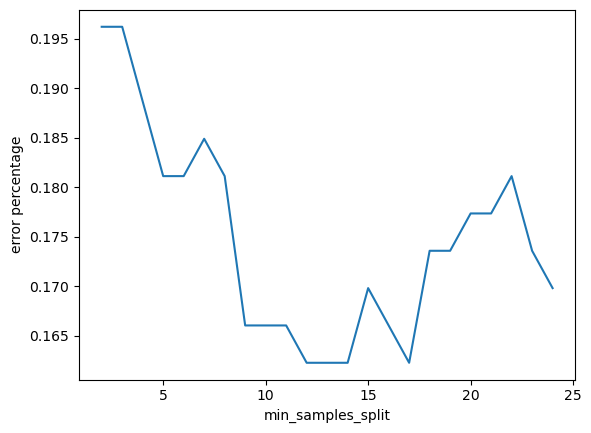

In [22]:
# Plot Test set Error rate as a function of minimum number of observations in a node before it can be split
fig, axes = plt.subplots()
x,test_error_plot = zip(*test_error)
axes.plot(x, test_error_plot)
plt.xlabel("min_samples_split")
plt.ylabel("error percentage")
plt.show()

Based on our observations, a good Random Forest for our dataset will have:
* at least 25 decision trees. Let's choose 50 just in case
* min_samples_split between 10 and 13.  Let's choose 12.  

Let's regrow a new Random Forest with these settings and save so it can be loaded again in a new Jupyter Notebook

In [23]:
RF_Final = RandomForestClassifier(n_estimators=50, min_samples_split=12, max_depth=None, oob_score=True, random_state=1)
RF_Final.fit(x_train, y_train)

y_pred = RF_Final.predict(x_test)
print("RF_Final Accuracy:",metrics.accuracy_score(y_test, y_pred))

RF_Final Accuracy: 0.8377358490566038


In [24]:
#Store the Random Forest to be used later in another Jupyter Notebook
import pickle

pickle.dump(RF_Final,open('RF_Final.pkl', 'wb'))

***Curiosity points (5 points)***
Play around with the ***max_depth*** variable to the RandomForestClassifier and see if that makes a difference.  

### Boosted decision trees

In [25]:
from sklearn.ensemble import AdaBoostClassifier
AB1 = AdaBoostClassifier(n_estimators=125, random_state=1)
AB1.fit(x_train, y_train)

y_pred = AB1.predict(x_test)
print("AB1 (Adaboost) Accuracy:",metrics.accuracy_score(y_test, y_pred))

AB1 (Adaboost) Accuracy: 0.8150943396226416


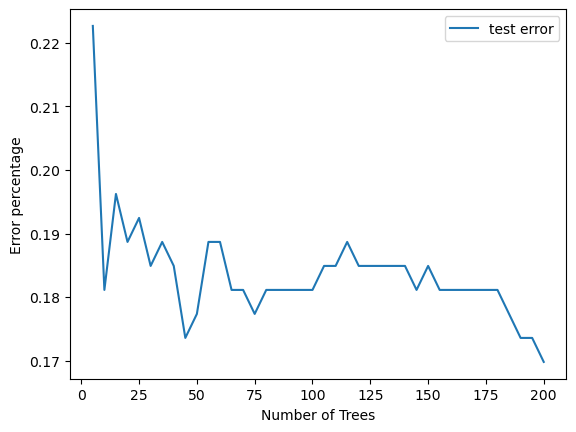

In [26]:
EnsembleGrowthErrorPlot(AB1, x_train, y_train, x_test, y_test, min_estimators=5, max_estimators =200, oob =False)

Generally, Adaboost suffers from **overfitting** when you increase the number of trees beyond a certain point.  For our test set, it looks like this number was around 50 trees, but the effect is slight.  Let's see if Gradient boost will be better 

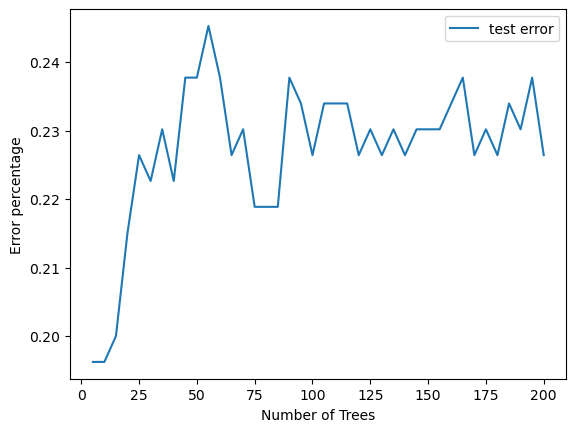

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
GB1 = GradientBoostingClassifier(n_estimators=125,learning_rate=1.0, random_state=1, max_depth=3)

EnsembleGrowthErrorPlot(GB1, x_train, y_train, x_test, y_test, min_estimators =5, max_estimators =200, oob =False)

Gradient Boost shows less susceptability to overfittiing, but a higher error rate.  